# Training a Vision Transformer Model with Tensorflow

The code for this tutorial is taken from [here](https://keras.io/examples/vision/image_classification_with_vision_transformer/).

### Import Required Packages

In [ ]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import PIL
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
!pip install tensorflow_addons
import tensorflow_addons as tfa
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Read in the Data
The following code will read in the cifar100 dataset to be used for model training.  Note that these images are RGB of size 32 x 32 x 3.

In [ ]:
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(labels)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

### Display the Data

In [ ]:
y_train_df = pd.DataFrame(y_train)
y_train_df.reset_index(inplace = True, drop = False)
y_train_df.columns = ['index', 'label']

## Extract first example for each category
examples = y_train_df.groupby('label').first()
examples.reset_index(inplace = True, drop = False)

In [ ]:
#Display the example images in a grid
fig, ax = plt.subplots(2, 5)
for i in range(examples.shape[0]):
    if (i - 5) < 0:
        y = 0
    else:
        y = 1
    x = i % 5

    ax[y, x].imshow(x_train[examples['index'][i], :, :, :])
    ax[y, x].set_title(labels[i])
    ax[y, x].axis('off')
fig.tight_layout()

### Data Augmentation

Data augmentation can be applied using the following where we normalize the image to mean zero and standard deviation1, resize the image to the desired size, randomly flip the images horizontally, randomly rotate the images, and randomly zoom.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

### Patch Creation

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
image_size = 32
patch_size = 4

plt.figure(figsize=(4, 4))
image = x_test[0]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

### Encodings

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

### Multilayer Perceptron (MLP)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

### Create a Model with the Prior Components

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

### Compile, Train, and Evaluate the Model

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
    )
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 32  # We'll resize input images to this size
patch_size = 4  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

vit_classifier = create_vit_classifier()

In [ ]:
vit_classifier.summary()

In [15]:
history = run_experiment(vit_classifier)

Epoch 1/100
176/176 [==============================] - 27s 107ms/step - loss: 2.0150 - accuracy: 0.3130 - top-5-accuracy: 0.8060 - val_loss: 1.5302 - val_accuracy: 0.4426 - val_top-5-accuracy: 0.9116
Epoch 2/100
176/176 [==============================] - 18s 101ms/step - loss: 1.5648 - accuracy: 0.4336 - top-5-accuracy: 0.8993 - val_loss: 1.2819 - val_accuracy: 0.5340 - val_top-5-accuracy: 0.9438
Epoch 3/100
176/176 [==============================] - 18s 101ms/step - loss: 1.4391 - accuracy: 0.4837 - top-5-accuracy: 0.9199 - val_loss: 1.2286 - val_accuracy: 0.5636 - val_top-5-accuracy: 0.9544
Epoch 4/100
176/176 [==============================] - 18s 101ms/step - loss: 1.3419 - accuracy: 0.5218 - top-5-accuracy: 0.9325 - val_loss: 1.1380 - val_accuracy: 0.5892 - val_top-5-accuracy: 0.9612
Epoch 5/100
176/176 [==============================] - 18s 100ms/step - loss: 1.2806 - accuracy: 0.5476 - top-5-accuracy: 0.9377 - val_loss: 1.0945 - val_accuracy: 0.6066 - val_top-5-accuracy: 0.9614


### Training Accuracy

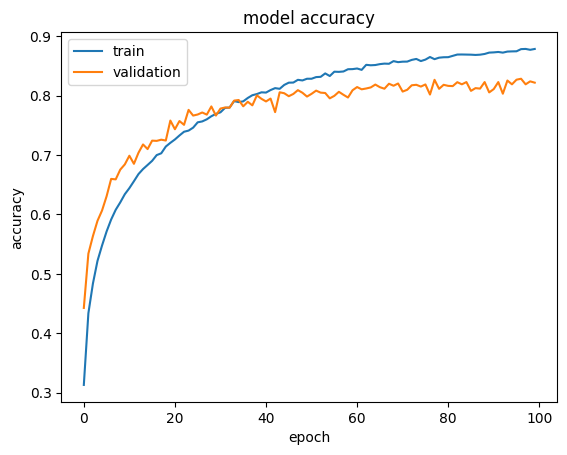

In [16]:
# Plot training accuracy by epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Training Loss

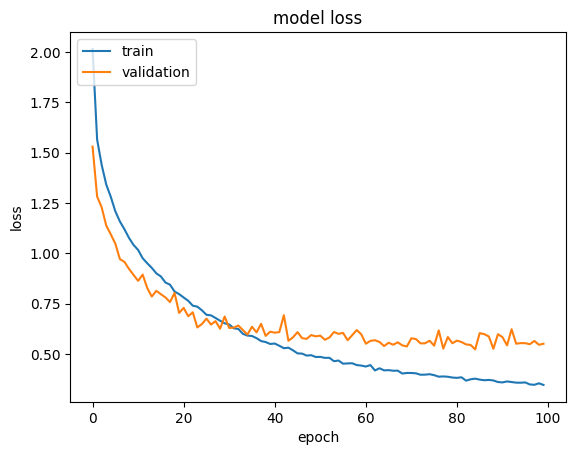

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Confusion Matrix

[Text(0, 0.5, 'plane'),
 Text(0, 1.5, 'car'),
 Text(0, 2.5, 'bird'),
 Text(0, 3.5, 'cat'),
 Text(0, 4.5, 'deer'),
 Text(0, 5.5, 'dog'),
 Text(0, 6.5, 'frog'),
 Text(0, 7.5, 'horse'),
 Text(0, 8.5, 'ship'),
 Text(0, 9.5, 'truck')]

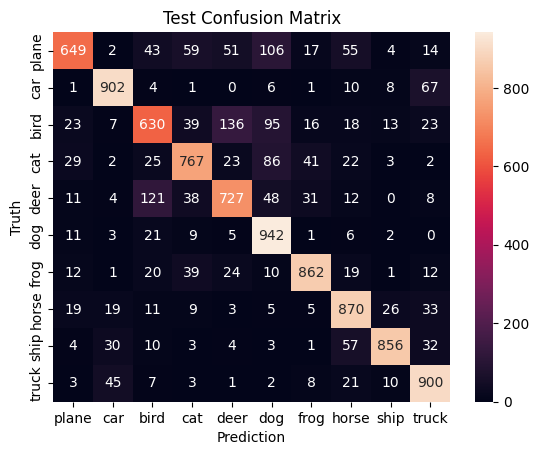

In [18]:
# Generate confusion matrix on test data
preds = pd.DataFrame(vit_classifier.predict(x_test))
preds = pd.DataFrame(preds.idxmax(axis=1))
preds.columns = ['index']
preds['label'] = preds['index'].apply(lambda x: labels[x])
y_test_df = pd.DataFrame(pd.DataFrame(y_test))
y_test_df.columns = ['index']
y_test_df['label'] = y_test_df['index'].apply(lambda x: labels[x])

fig = sns.heatmap(confusion_matrix(y_true = y_test_df['label'], y_pred = preds['label']), annot = True, fmt = 'g')
fig.set(xlabel = 'Prediction', ylabel = 'Truth', xticklabels = labels, title = 'Test Confusion Matrix')
fig.set_yticklabels(labels, va = 'center')

###  Saliency Mapping

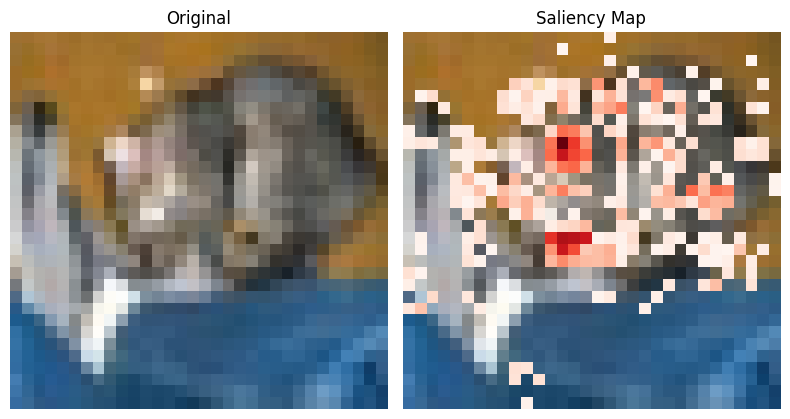

In [19]:
img1 = x_test[0, :, :, :]
img = np.expand_dims(img1, axis=0)
y_pred = vit_classifier.predict(img)

images = tf.Variable(img, dtype=float)

with tf.GradientTape() as tape:
    pred = vit_classifier(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]

grads = tape.gradient(loss, images)

dgrad_abs = tf.math.abs(grads)

dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
## normalize to range between 0 and 1
arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
grad_eval[grad_eval < np.percentile(0.2, grad_eval)] = np.nan

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].set_title('Original')
ax[0].imshow(img1)
ax[0].axis('off')
ax[1].set_title('Saliency Map')
ax[1].imshow(img1)
ax[1].imshow(grad_eval, cmap='Reds')
ax[1].axis('off')
plt.tight_layout()